In [1]:
from keras.models import Sequential, load_model
from keras import layers
from keras.optimizers import Adam
from keras.losses import categorical_crossentropy
from keras.activations import relu, softmax
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG19, RegNetX032, MobileNet
from keras.src.callbacks import History, ModelCheckpoint, EarlyStopping

from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

In [2]:
DATASET_PATH: str = '/content/drive/MyDrive/datasets/7-7-faces'
INPUT_SHAPE: tuple[int, int, int] = (244, 244, 3)
EPOCHS: int = 40
MODEL_SAVE_PATH: str = '/content/drive/MyDrive/weights/7-7-faces-best-version2.keras'

### Load The Dataset

In [3]:
idg = ImageDataGenerator(
    rescale=1./255,
    zoom_range=.05,
    horizontal_flip=True,
    validation_split=.05,
)

In [4]:
train_dataset = idg.flow_from_directory(
    DATASET_PATH,
    target_size=INPUT_SHAPE[:2],
    batch_size=32,
    subset='training',
)

validation_dataset = idg.flow_from_directory(
    DATASET_PATH,
    target_size=INPUT_SHAPE[:2],
    batch_size=32,
    subset='validation',
)

Found 1296 images belonging to 14 classes.
Found 62 images belonging to 14 classes.


### Training Part

In [ ]:
# regnet = RegNetX032(include_top=False, weights='imagenet', input_shape=INPUT_SHAPE)
# regnet.summary()

# vgg = VGG19(include_top=False, weights='imagenet', input_shape=INPUT_SHAPE)
# vgg.summary()

mobilenet = MobileNet(include_top=False, weights='imagenet', input_shape=INPUT_SHAPE)
mobilenet.summary()

In [12]:
# len(regnet.layers)
# len(vgg.layers)
len(mobilenet.layers)

86

In [13]:
for layer in mobilenet.layers[:7]:
# for layer in vgg.layers[:5]:
# for layer in regnet.layers[:15]:
    print(layer.name)
    layer.trainable = False

input_2
conv1
conv1_bn
conv1_relu
conv_dw_1
conv_dw_1_bn
conv_dw_1_relu


In [14]:
model: Sequential = Sequential([
    # regnet,
    # vgg,
    mobilenet,

    layers.Flatten(),

    # layers.Dense(256, relu),
    # layers.Dropout(.2),

    layers.Dense(125, relu),
    layers.Dropout(.2),

    layers.Dense(14, softmax)
])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functi  (None, 7, 7, 1024)        3228864   
 onal)                                                           
                                                                 
 flatten_1 (Flatten)         (None, 50176)             0         
                                                                 
 dense_2 (Dense)             (None, 125)               6272125   
                                                                 
 dropout_1 (Dropout)         (None, 125)               0         
                                                                 
 dense_3 (Dense)             (None, 14)                1764      
                                                                 
Total params: 9502753 (36.25 MB)
Trainable params: 9479585 (36.16 MB)
Non-trainable params: 23168 (90.50 KB)
___________

In [15]:
model.compile(
    optimizer=Adam(),
    loss=categorical_crossentropy,
    metrics=['accuracy']
)

checkpoint = ModelCheckpoint(MODEL_SAVE_PATH, save_best_only=True)
stop = EarlyStopping(patience=8)

In [16]:
history: History = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=EPOCHS,
    callbacks=[stop, checkpoint]
)

Epoch 1/40
41/41 [==============================] - 658s 16s/step - loss: 4.1726 - accuracy: 0.4097 - val_loss: 4.0225 - val_accuracy: 0.1129
Epoch 2/40
41/41 [==============================] - 31s 743ms/step - loss: 0.9482 - accuracy: 0.6705 - val_loss: 4.5853 - val_accuracy: 0.3065
Epoch 3/40
41/41 [==============================] - 32s 789ms/step - loss: 0.6318 - accuracy: 0.8032 - val_loss: 2.7438 - val_accuracy: 0.5000
Epoch 4/40
41/41 [==============================] - 33s 804ms/step - loss: 0.5366 - accuracy: 0.8287 - val_loss: 2.6758 - val_accuracy: 0.5484
Epoch 5/40
41/41 [==============================] - 33s 827ms/step - loss: 0.3944 - accuracy: 0.8650 - val_loss: 2.2467 - val_accuracy: 0.5968
Epoch 6/40
41/41 [==============================] - 33s 795ms/step - loss: 0.3811 - accuracy: 0.8889 - val_loss: 0.9869 - val_accuracy: 0.8387
Epoch 7/40
41/41 [==============================] - 31s 770ms/step - loss: 0.3482 - accuracy: 0.9012 - val_loss: 1.5111 - val_accuracy: 0.7419


In [17]:
# del model
model: Sequential = load_model(MODEL_SAVE_PATH)
model.evaluate(validation_dataset)

2/2 [==============================] - 2s 627ms/step - loss: 0.4904 - accuracy: 0.8710


[0.4904129207134247, 0.8709677457809448]

In [ ]:
Y_true = []
Y_pred = []

for i in range(2):
    images = validation_dataset[i][0]
    labels = validation_dataset[i][1]

    for image, label in zip(images, labels):
        image = np.expand_dims(image, axis=0)
        Y_pred.append(np.argmax(
            model.predict(image)
        ))

        Y_true.append(np.argmax(label.tolist()))

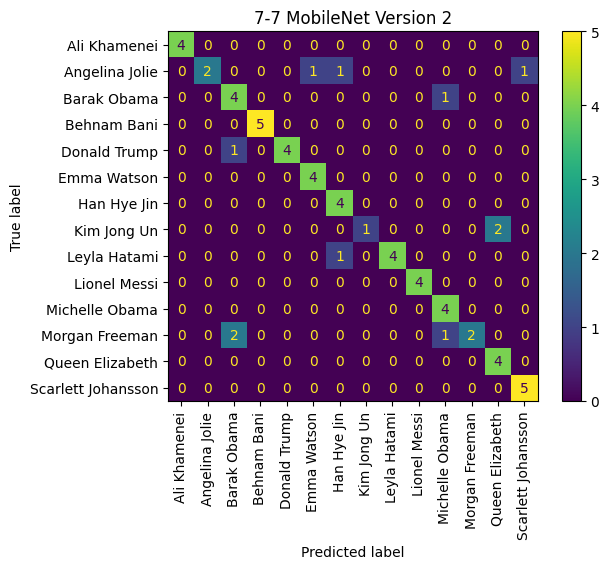

In [19]:
labels = [
    'Ali Khamenei', 'Angelina Jolie', 'Barak Obama', 'Behnam Bani', 'Donald Trump',
    'Emma Watson', 'Han Hye Jin', 'Kim Jong Un', 'Leyla Hatami', 'Lionel Messi',
    'Michelle Obama', 'Morgan Freeman', 'Queen Elizabeth', 'Scarlett Johansson'
]

cm = confusion_matrix(Y_true, Y_pred)
display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

display.plot(xticks_rotation=90)
plt.title(f'7-7 MobileNet Version 2')
plt.show()

### Inference

In [20]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
model: Sequential = load_model(MODEL_SAVE_PATH)
print('Model Loaded.')

Model Loaded.


In [21]:
def inference(image_path: str, show: bool = True) -> str:
    global model

    labels = [
        'Ali Khamenei', 'Angelina Jolie', 'Barak Obama', 'Behnam Bani', 'Donald Trump',
        'Emma Watson', 'Han Hye Jin', 'Kim Jong Un', 'Leyla Hatami', 'Lionel Messi',
        'Michelle Obama', 'Morgan Freeman', 'Queen Elizabeth', 'Scarlett Johansson'
    ]

    test_img = cv.imread(image_path)




    if show:
        plt.title(
            (image_path.split('/')[-1]).split('.')[0]
        )
        plt.imshow(cv.cvtColor(test_img, cv.COLOR_BGR2RGB))

    test_img = cv.cvtColor(test_img, cv.COLOR_BGR2RGB)
    test_img = test_img / 255.
    test_img = cv.resize(test_img, INPUT_SHAPE[:2])
    prediction = np.argmax(model.predict(
        np.expand_dims(test_img, axis=0)
    ))
    return labels[prediction], prediction

1/1 [==============================] - 0s 423ms/step


('Scarlett Johansson', 13)

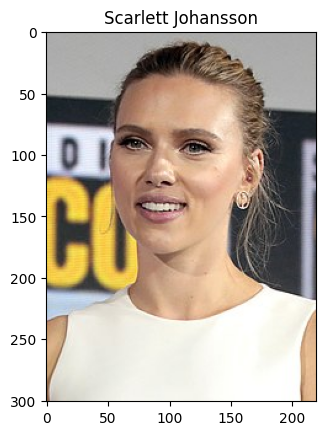

In [22]:
result = inference(image_path='/content/drive/MyDrive/datasets/7-7-test-faces/Scarlett Johansson.jpg', show=True)
result

1/1 [==============================] - 0s 20ms/step


('Ali Khamenei', 0)

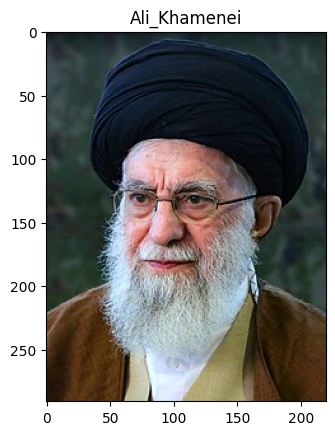

In [23]:
result = inference(image_path='/content/drive/MyDrive/datasets/7-7-test-faces/Ali_Khamenei.jpg', show=True)
result

1/1 [==============================] - 0s 23ms/step


('Behnam Bani', 3)

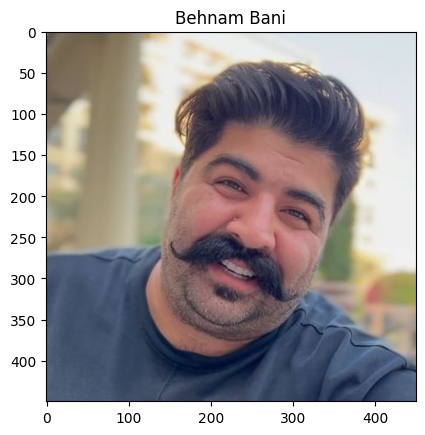

In [24]:
result = inference(image_path='/content/drive/MyDrive/datasets/7-7-test-faces/Behnam Bani.jpg', show=True)
result

1/1 [==============================] - 0s 31ms/step


('Donald Trump', 4)

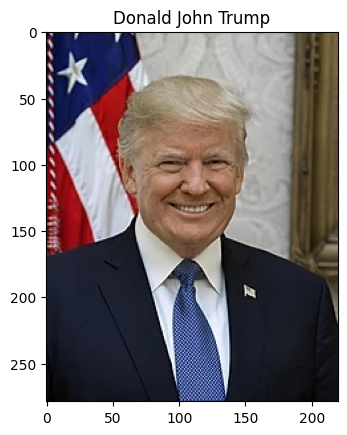

In [25]:
result = inference(image_path='/content/drive/MyDrive/datasets/7-7-test-faces/Donald John Trump.jpg', show=True)
result